## Subtask 1

After googling ".nii python" I quickly found 

- https://nipy.org/nibabel/nifti_images.html
- https://neuraldatascience.io/8-mri/nifti.html

I followed the instructions, experimented here and from this I implemented `load_nifti.py`

In [68]:
import nibabel as nib
import matplotlib.pyplot as plt

In [69]:
nii_path = 'data/BraTS20_Validation_002_flair.nii'
nii_object = nib.load(nii_path)

nii_object.shape

(240, 240, 155)

In [70]:
print(nii_object.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 239.0
qoffset_z       : 0.0

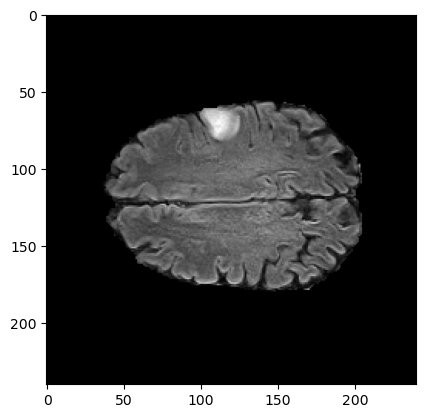

In [71]:
# get floating point data
img_data = nii_object.get_fdata()

x = 99
slice_at_x = img_data[:,:,x]

plt.imshow(slice_at_x, cmap='gray')
plt.show()

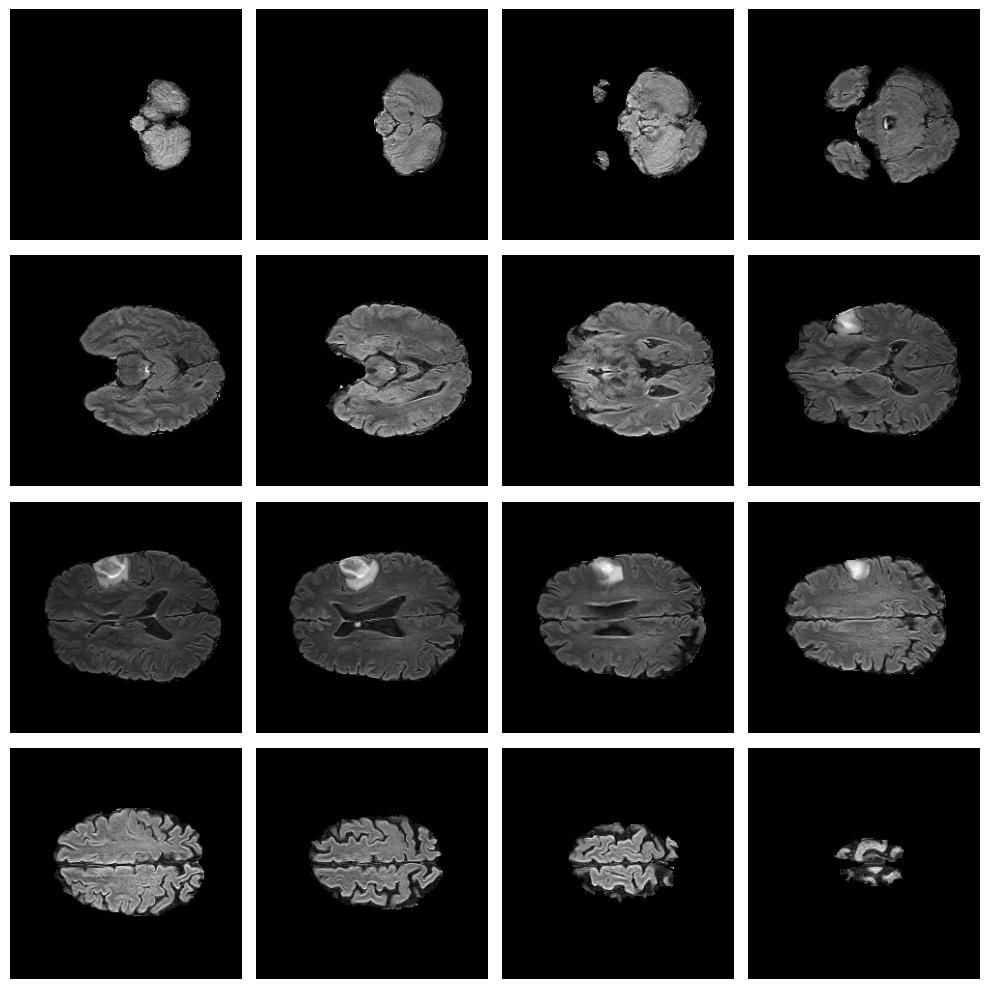

In [72]:
# explore the image series

# grid setup
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols

# iterator setup
n_slices = img_data.shape[2]
step_size = n_slices // n_subplots
# avoid out of bounds
slice_indices = list(range(0, n_slices, step_size))[:n_subplots]

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for ix, img_ix in enumerate(slice_indices):
    axs.flat[ix].imshow(img_data[:, :, img_ix], cmap='gray')
    axs.flat[ix].axis('off')
        
plt.tight_layout()
plt.show()


## Subtask 2

Before working on this subtask I did some online research and braistormed a little bit.

When facing ML tasks like this I always try to look for publications on the topic and see what people might already have come up with on kaggle or similar competition sites.

#### Online Research

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data  is this the same data set?

https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy  informative guide

https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5 publication on the topic

#### Image Classification Brainstorming

To address the class imbalance:
- Over and/or undersampling
- Augmentation techniques
- Weighted loss function (cross entropy, focal loss)
- Transfer learning
- Evaluation metrics: precision, recall, F1-score, ROC-AUC, and the confusion matrix

In [54]:
import os

# pytorch imports
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# other imports
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

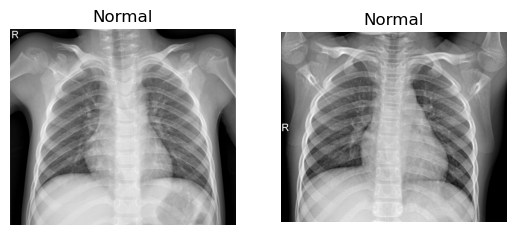

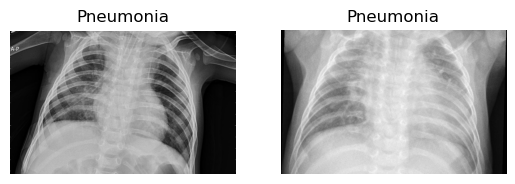

In [26]:
# Example images

train_normal = "data/train/NORMAL"
train_pneumonia = "data/train/PNEUMONIA"

def show_sample_images(folder, label, num=2):
    files = os.listdir(folder)[:num]
    for i, file in enumerate(files):
        img = Image.open(os.path.join(folder, file))
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

show_sample_images(train_normal, "Normal")
show_sample_images(train_pneumonia, "Pneumonia")


In [43]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert RGB to grayscale
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

batch_size = 32

# Create custom datasets using ImageFolder
trainset = ImageFolder(root='data/train', transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

valset = ImageFolder(root='data/val', transform=transform)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = trainset.classes  # Automatically fetch class names from folders


In [44]:
trainset.class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}
valset.class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}

In [45]:
pd.Series(trainset.targets).value_counts()

1    3687
0     997
Name: count, dtype: int64

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Change input channels to 1
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [35]:
net = Net()

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}', end='\r')
            running_loss = 0.0

print('Finished Training')


Finished Training0, Loss: 0.024


In [ ]:
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)  # Recall for class 1
    specificity = tn / (tn + fp)  # Recall for class 0
    
    return accuracy, sensitivity, specificity, cm

In [40]:
net.eval()  # Set model to evaluation mode
all_preds, all_labels = [], []

with torch.no_grad():
    for data in valloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

In [41]:
accuracy, sensitivity, specificity, cm = calculate_metrics(all_labels, all_preds)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print("Confusion Matrix:")
print(cm)


Accuracy: 0.9113
Sensitivity: 0.9966
Specificity: 0.8259
Confusion Matrix:
[[242  51]
 [  1 292]]


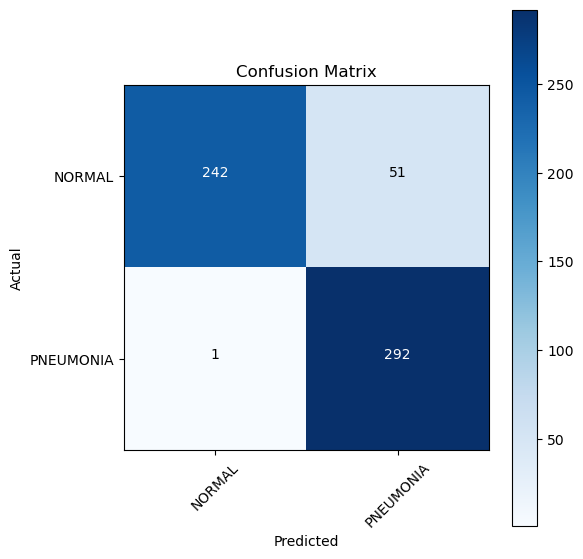

In [52]:
class_labels = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))

plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = range(len(class_labels))

plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Labels for the confusion matrix